--------------------------------------------------------------------
ER background from materials. 
----------------------------------------------------------------
notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [112]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'
print("done!")


loading....
server chosen is: /userdata/arocchetti/rootfiles/
done!


In [131]:
#list of components and isotopes used in this analysis.

components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate" #includes also top ring
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]

In [110]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component) 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events = calculate_events(data, isotope)
 
        #print("---", isotope, n, N, frac, n_events, b )
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        contamination = p[isotope]/1000 
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
#             contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            #print("----", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*kg
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
                       
            if n_events == 2.3: 
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################


In [107]:
#Cell calculates the rate for the Cryostats
m_fv = 4
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
    print("^Tot.^^^^^^^^^", "%.2g" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 


^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|OuterCryostat_Elongation|(0.17 +- 0.53) |(0.086 +- 0.066) |(0.04 +- 0.068) |(0.00028 +- 0.0009) |(0.066 +- 0.15) | <0.64*|(0.025 +- 0.11) |(1.3 +- 1.2) |**<2.4 **|
|OuterCryostatShell| <2.3 |(7.2 +- 2.5) |(0.22 +- 0.22)*|(0.024 +- 0.035)*|(0.21 +- 0.21)*| <0.23 |(0.052 +- 0.069) |(1.4 +- 0.82)*|**<12 **|
|OuterCryostat_flanges|(0.029 +- 0.13) |(2.6 +- 2.8) |(0.46 +- 0.46)*|(0.0062 +- 0.028)*|(0.13 +- 0.58) | <0.12 | <0.2 |(2.7 +- 2.8)*|**<6.2 **|
|SS_InnerCryostatShell|(0.28 +- 0.56) |(1.4 +- 0.47) |(0.19 +- 0.15) |(0.015 +- 0.014)*|(0.63 +- 0.39) | <1.1 |(0.03 +- 0.039) |(0.17 +- 0.18) |**<3.8 **|
|SS_InnerCryostatFlanges| <2.6 |(12 +- 8.4) |(0.13 +- 0.35)*|(0.036 +- 0.093)*|(0.51 +- 1.6) | <0.24 | <0.39 |(5.8 +- 5.8)*|**<22 **|
|SS_InnerCryostat_bottomDome| <1.1 |(0.00071 +- 0.0032) | <0.074 | <0.0018 | <0.21 | <0.18*| <0.32 | <0.64 |**<2.5 **|
^Tot.^^^^^^^^^ 48 ev/t*y^


In [103]:
#----------BELL----------------
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|SS_BellPlate|(0.19 +- 0.13) |(1.5 +- 0.19) |(0.064 +- 0.033) |(0.0095 +- 0.0032)*|(0.12 +- 0.053) |(0.039 +- 0.042) |(0.023 +- 0.02) |(0.12 +- 0.057) |(**2.1 +- 0.53)**|
|SS_BellSideWall|(0.0032 +- 0.014) |(0.0059 +- 0.0034) |(0.0045 +- 0.0045) |(2.2e-05 +- 5e-05) |(0.0038 +- 0.007) |(0.00055 +- 0.0024)*|(0.0077 +- 0.012) |(0.038 +- 0.039) |(**0.064 +- 0.083)**|
|SS_BellSideWallBottomLip| <0.092 |(0.00065 +- 0.00093) |(3.8e-05 +- 0.00017)*|(0.00013 +- 0.00026)*| <0.021 | <0.045*|(0.00032 +- 0.0014) |(0.00087 +- 0.0039) |**<0.16 **|
^Tot.^^^^^^^^^ 2.3032 ev/t*y^


In [104]:
#-----------Teflon ----------------
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Teflon_Pillar_|(0.003 +- 0.0029) | no contamination value |(0.0025 +- 0.0018)*|(0.00015 +- 7.7e-05)*|(0.0026 +- 0.0015)*|(0.0016 +- 0.0016)*|(0.0031 +- 0.0022) |(0.0046 +- 0.0023) |(**0.017 +- 0.012)**|
|Teflon_TPC_Sliding|(0.00045 +- 0.00049) | no contamination value |(0.00024 +- 0.00014) |(0.00016 +- 6.7e-05)*|(0.00066 +- 0.00047)*|(0.007 +- 0.0017)*|(0.00042 +- 0.00031) |(0.0016 +- 0.0012) |(**0.011 +- 0.0044)**|
|Teflon_TPC_Fixed|(0.00015 +- 0.00015)*| no contamination value |(0.037 +- 0.017) |(0.00036 +- 0.00015)*|(0.0011 +- 0.00081)*|(0.013 +- 0.0032)*|(0.0027 +- 0.0014) |(0.00053 +- 0.00037)*|(**0.054 +- 0.023)**|
|Teflon_BottomTPC|(1.9e-06 +- 4.9e-06) | no contamination value |(4.4e-05 +- 7.4e-05) |(7.9e-07 +- 1.8e-06)*|(1e-05 +- 7.4e-06)*|(1.4e-05 +- 1.4e-05)*|(4.6e-06 +- 1.1e-05) |(4.1e-05 +- 2e-05)*|(**0.00012 +- 0.00013)**|
^Tot.^^^^^^^^^ 0.0825 ev/t*y^


In [105]:
#-----------Copper ----------------
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]


#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Copper_TopRing|(0.0018 +- 0.0057)*|(0.0011 +- 0.0006)*|(0.00074 +- 0.0019) |(0.00021 +- 0.00035)*|(0.0028 +- 0.0062) |(8e-05 +- 0.00035)*|(0.0039 +- 0.0063) |(0.0059 +- 0.0099)*|(**0.016 +- 0.031)**|
|Copper_FieldGuard_|(0.004 +- 0.0031) | no contamination value | no contamination value | no contamination value |(0.0028 +- 0.002) |(0.00069 +- 0.00042) |(0.0034 +- 0.002) | no contamination value |(**0.011 +- 0.0076)**|
|Copper_FieldShaperRing_|(0.011 +- 0.011)*|(0.1 +- 0.011) |(0.0037 +- 0.002) |(0.00012 +- 5.2e-05)*|(0.00017 +- 0.00017)*|(0.016 +- 0.0045)*|(0.00036 +- 0.00021)*|(0.0027 +- 0.0012)*|(**0.14 +- 0.03)**|
|Copper_BottomPmtPlate|(0.033 +- 0.046)*|(0.033 +- 0.0068) |(0.012 +- 0.0061)*|(0.00035 +- 0.00025)*|(0.0026 +- 0.0026)*| <0.15*|(0.0073 +- 0.0041)*|(0.013 +- 0.0065)*|**<0.25 **|
^Tot.^^^^^^^^^ 0.4190 ev/t*y^


In [106]:
#----------- Others ----------------
components = ["PmtTpc",
             "SS_AnodeRing",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv)

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|PmtTpc|( 4 +- 3.1) |(2.9 +- 0.89) |(6.3 +- 2.3) |(0.053 +- 0.034) |(0.63 +- 0.38) | <0.4 |(0.63 +- 0.35) |(0.86 +- 0.46) |**<16 **|
|SS_AnodeRing| <0.018 |(0.00075 +- 0.00047) |(2.3e-05 +- 5.9e-05)*|(2e-05 +- 4.5e-05)*|(0.0008 +- 0.0012) | <0.0089*|(0.0013 +- 0.0013) |(0.0034 +- 0.0034) |**<0.033 **|
^Tot.^^^^^^^^^ 15.7293 ev/t*y^


In [ ]:
# PLOTS

working on: OuterCryostat_Elongation
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: OuterCryostatShell
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: OuterCryostat_flanges
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: SS_InnerCryostatShell
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: SS_InnerCryostatFlanges
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 -----------

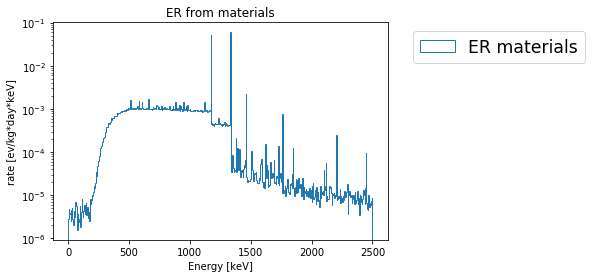

file saved as: Cryostat.json


In [113]:
bins = 500
min_val = 0
max_val = 2500
#plot cryostat
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "Cryostat")

working on: SS_BellPlate
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: SS_BellSideWall
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: SS_BellSideWallBottomLip
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500


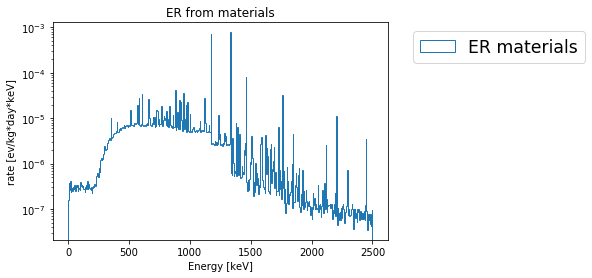

file saved as: Bell.json


In [114]:
#plot Bell
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "Bell")

working on: Teflon_Pillar_
U238 ----------- 500
no contamination for  Co60
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: Teflon_TPC_Sliding
U238 ----------- 500
no contamination for  Co60
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: Teflon_TPC_Fixed
U238 ----------- 500
no contamination for  Co60
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: Teflon_BottomTPC
U238 ----------- 500
no contamination for  Co60
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500


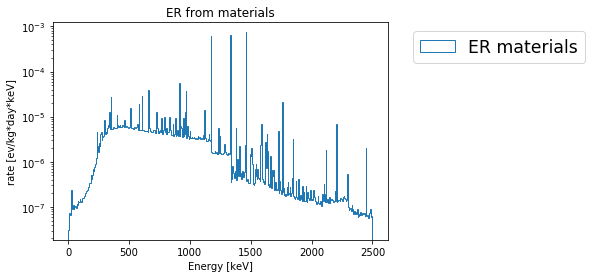

file saved as: Teflon.json


In [115]:
#plot Teflon
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "Teflon")

working on: Copper_TopRing
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: Copper_FieldGuard_
U238 ----------- 500
no contamination for  Co60
Co60 ----------- 500
no contamination for  K40
K40 ----------- 500
no contamination for  Cs137
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
no contamination for  Ra226
Ra226 ----------- 500
working on: Copper_FieldShaperRing_
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500
working on: Copper_BottomPmtPlate
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500


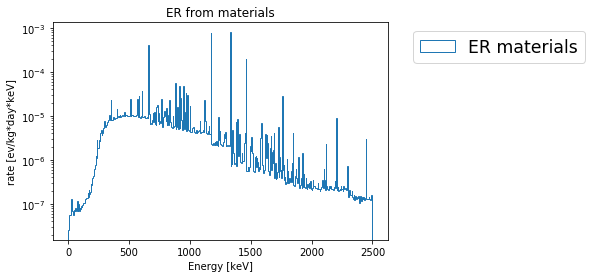

file saved as: Copper.json


In [116]:
#plot Copper
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "Copper")

working on: PmtTpc
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500


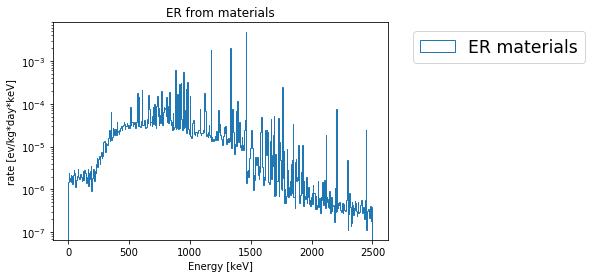

file saved as: pmt.json


In [117]:
#plot pmt
components = ["PmtTpc"]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "pmt")

working on: SS_AnodeRing
U238 ----------- 500
Co60 ----------- 500
K40 ----------- 500
Cs137 ----------- 500
Th228 ----------- 500
U235 ----------- 500
Th232 ----------- 500
Ra226 ----------- 500


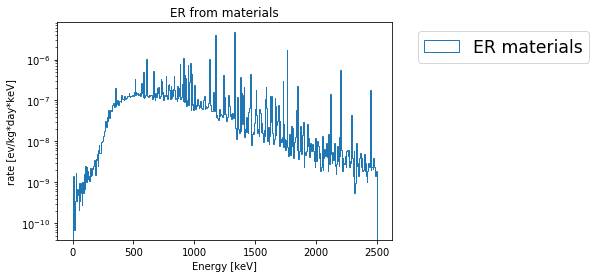

file saved as: electrodes.json


In [118]:
#plot electrodes
components = ["SS_AnodeRing"]
values, bins_plt = plot_total_contribution(bins, min_val, max_val )
make_spectrum(values, "electrodes")

In [ ]:
#-----extra plots-------------

In [120]:
def load_files():

    with open('Cryostat.json') as json_file:
        cryo = json.load(json_file)
    with open('Bell.json') as json_file:
        bell = json.load(json_file)   
    with open('pmt.json') as json_file:
        pmt = json.load(json_file)   
    with open('Teflon.json') as json_file:
        teflon = json.load(json_file)   
    with open('Copper.json') as json_file:
        copper = json.load(json_file) 
    with open('electrodes.json') as json_file:
        electrodes = json.load(json_file) 
    total = np.zeros(len(cryo["map"]))
    for i in range(0, len(cryo["map"])):
        total[i]= cryo["map"][i] + bell["map"][i] + pmt["map"][i]+teflon["map"][i]+copper["map"][i]+electrodes["map"][i]
    
    return total, cryo, bell, pmt, teflon, copper, electrodes
total, cryo, bell, pmt, teflon, copper, electrodes = load_files()

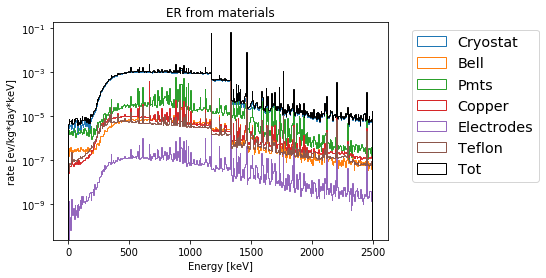

In [121]:
n_bins = (max_val-min_val)/bins
bins_plt = np.arange(min_val, max_val, n_bins)
 
def plot_bello(total, cryo, bell, pmt, teflon, copper, electrodes):
    plt.hist( bins_plt, bins_plt, weights =  cryo["map"],histtype = "step",  label = "Cryostat")
    plt.hist( bins_plt, bins_plt, weights = bell["map"], histtype = "step",label = "Bell")
    plt.hist( bins_plt, bins_plt, weights =  pmt["map"], histtype = "step",label = "Pmts")
    plt.hist( bins_plt, bins_plt, weights =  copper["map"], histtype = "step",label = "Copper")
    plt.hist( bins_plt, bins_plt, weights =  electrodes["map"] , histtype = "step",label = "Electrodes")
    plt.hist( bins_plt, bins_plt, weights =  teflon["map"] ,histtype = "step", label = "Teflon")
    plt.hist( bins_plt, bins_plt, weights =  total, histtype = "step", color = "black", label = "Tot")
    plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-large')
    plt.yscale("log")
    plt.ylabel("rate [ev/kg*day*keV]")
    plt.xlabel("Energy [keV]")
    plt.title("ER from materials")
    plt.show()
plot_bello(total, cryo, bell, pmt, teflon, copper, electrodes)

working on: PmtTpc
U238
Co60
K40
Cs137
Th228
U235
Th232
Ra226


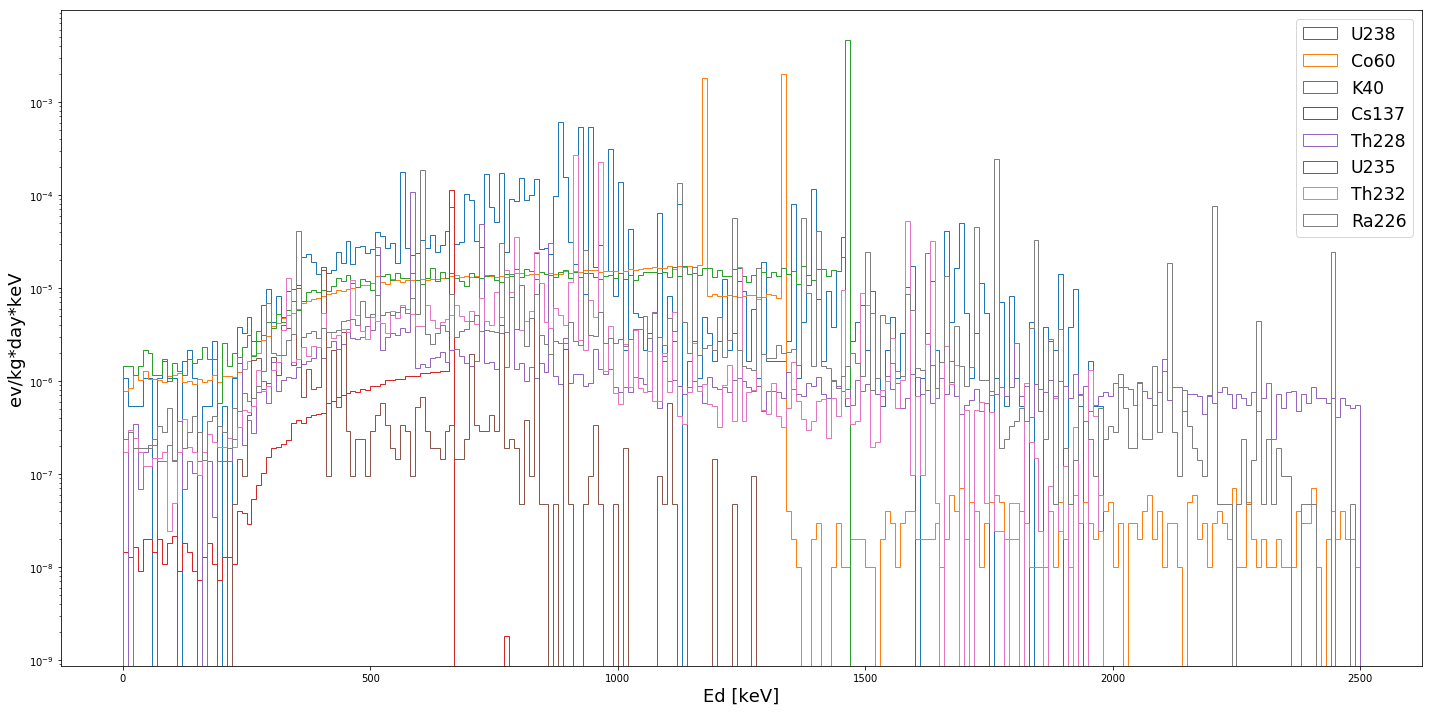

In [133]:
components = ["PmtTpc"]

###plot spectrum per component 
def plot_spectrum_comp(data, min_,max_, bins_, isotope, time):
    time_weights = (1/time)*(864/400)
    counts, bins = np.histogram(data.Ed, bins = bins_, range = (min_, max_))  
    counts1 = counts*time_weights
    plt.hist(bins[:-1], bins, weights=counts1, label = isotope, histtype = "step")
    plt.ylabel('ev/kg*day*keV', fontsize=18)
    plt.xlabel('Ed [keV]', fontsize=18)
    plt.yscale('log')
    plt.tight_layout()
    plt.legend(fontsize='xx-large')
    
for component in components:
    fig= plt.figure(figsize=(20,10))
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        print(isotope)
        data2, frac, material = get_data(isotope, component)
        data = fv(data2)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum_comp(data, 0, 2500, 250, isotope, time) 
    plt.show()